In [1]:
%matplotlib inline

import warnings
import os
from pathlib import Path
import quandl
import numpy as np
from numpy.random import choice, normal
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier, BaggingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve

warnings.filterwarnings('ignore')

In [2]:
plt.style.use('fivethirtyeight')
np.random.seed(seed=42)

## Get Data

In [3]:
with pd.HDFStore('../data/data.h5') as store:
    data = store['engineered_features']

    data = (data
            .drop([c for c in data.columns if c.startswith('target') 
                      and not c.startswith('target_1m')], axis=1)
            .rename(columns={'target_1m': 'returns'})
            .dropna())

dummy_data = (pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
              .pipe(lambda x: x.rename(columns={c:c.replace('.0', '') for c in x.columns})))
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 431221 entries, (A, 2001-07-31 00:00:00) to (ZUMZ, 2018-02-28 00:00:00)
Data columns (total 85 columns):
return_1m                431221 non-null float64
return_2m                431221 non-null float64
return_3m                431221 non-null float64
return_6m                431221 non-null float64
return_9m                431221 non-null float64
return_12m               431221 non-null float64
CMA                      431221 non-null float64
HML                      431221 non-null float64
Mkt-RF                   431221 non-null float64
RMW                      431221 non-null float64
SMB                      431221 non-null float64
momentum_2               431221 non-null float64
momentum_3               431221 non-null float64
momentum_6               431221 non-null float64
momentum_9               431221 non-null float64
momentum_12              431221 non-null float64
momentum_3_12            431221 non-null float64
return_1m_t-

### Stock Prices

In [4]:
y = dummy_data.returns
y_binary = (y > 0).astype(int)
X = dummy_data.drop('returns', axis=1)

## Explore Data

In [5]:
y.describe(percentiles=np.arange(.1, .91, .1))

count    431221.000000
mean          0.011678
std           0.117853
min          -0.346734
10%          -0.118016
20%          -0.065091
30.0%        -0.034006
40%          -0.010690
50%           0.009015
60%           0.029351
70%           0.052545
80%           0.083434
90%           0.139514
max           0.455373
Name: returns, dtype: float64

## Custom KFold

In [6]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""
    def __init__(self, n_splits=3):
        self.n_splits = n_splits

    def split(self, X, y=None, groups=None):
        dates = np.sort(X.index.get_level_values('date').unique())[::-1]
        X['idx'] = range(len(X))
        for date in dates[:self.n_splits]:
            train_idx = X.loc[X.index.get_level_values('date') < date, 'idx'].values
            test_idx = X.loc[X.index.get_level_values( 'date') == date, 'idx'].values
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

## Benchmarks

### Regression

In [7]:
def regression_benchmark():
    rmse = []
    for train_idx, test_idx in cv.split(X):
        mean = y.iloc[train_idx].mean()
        data = y.iloc[test_idx].to_frame('y_test').assign(y_pred=mean)
        rmse.append(np.sqrt(mean_squared_error(data.y_test, data.y_pred))) 
    return np.mean(rmse)

### Classification

In [8]:
def classification_benchmark():
    auc = []
    for train_idx, test_idx in cv.split(X):
        mean = y_binary.iloc[train_idx].mean()
        data = y_binary.iloc[test_idx].to_frame('y_test').assign(y_pred=mean)
        auc.append(roc_auc_score(data.y_test, data.y_pred))
    return np.mean(auc)

## Bagging

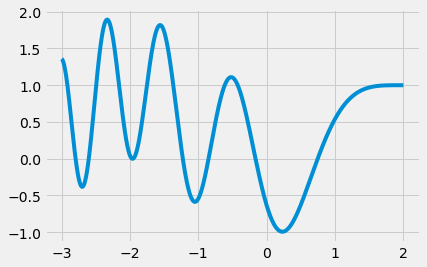

In [9]:
def f(x):
    return np.exp(-(x+2) ** 2) + np.cos((x-2)**2)

x = np.linspace(-3, 2, 1000)
y = pd.Series(f(x), index=x)
y.plot();

In [10]:
test_size = 500
train_size = 250
reps = 100

noise = .5  # noise relative to std(y)
noise = y.std() * noise

X_test = choice(x, size=test_size, replace=False)

max_depth = 10
n_estimators=10

tree = DecisionTreeRegressor(max_depth=max_depth)
bagged_tree = BaggingRegressor(base_estimator=tree, n_estimators=n_estimators)
learners = {'Decision Tree': tree, 'Bagging Regressor': bagged_tree}

predictions = {k: pd.DataFrame() for k, v in learners.items()}
for i in range(reps):
    X_train = choice(x, train_size)
    y_train = f(X_train) + normal(scale=noise, size=train_size)
    for label, learner in learners.items():
        learner.fit(X=X_train.reshape(-1, 1), y=y_train)
        preds = pd.DataFrame({i: learner.predict(X_test.reshape(-1, 1))}, index=X_test)
        predictions[label] = pd.concat([predictions[label], preds], axis=1)

In [11]:
# y only observed with noise
y_true = pd.Series(f(X_test), index=X_test)
y_test = pd.DataFrame(y_true.values.reshape(-1,1) + normal(scale=noise, size=(test_size, reps)), index=X_test)

In [12]:
result = pd.DataFrame()
for label, preds in predictions.items():
    result[(label, 'error')] = preds.sub(y_test, axis=0).pow(2).mean(1)    # mean squared error
    result[(label, 'bias')] = y_true.sub(preds.mean(axis=1), axis=0).pow(2)             # bias
    result[(label, 'variance')] = preds.var(axis=1)
    result[(label, 'noise', )] = y_test.var(axis=1)
result.columns = pd.MultiIndex.from_tuples(result.columns)

In [13]:
df = result.mean().sort_index().loc['Decision Tree']
f"{(df.error- df.drop('error').sum()) / df.error:.2%}"

'0.29%'

In [14]:
df = result.mean().sort_index().loc['Bagging Regressor']
f"{(df.error- df.drop('error').sum()) / df.error:.2%}"

'0.22%'

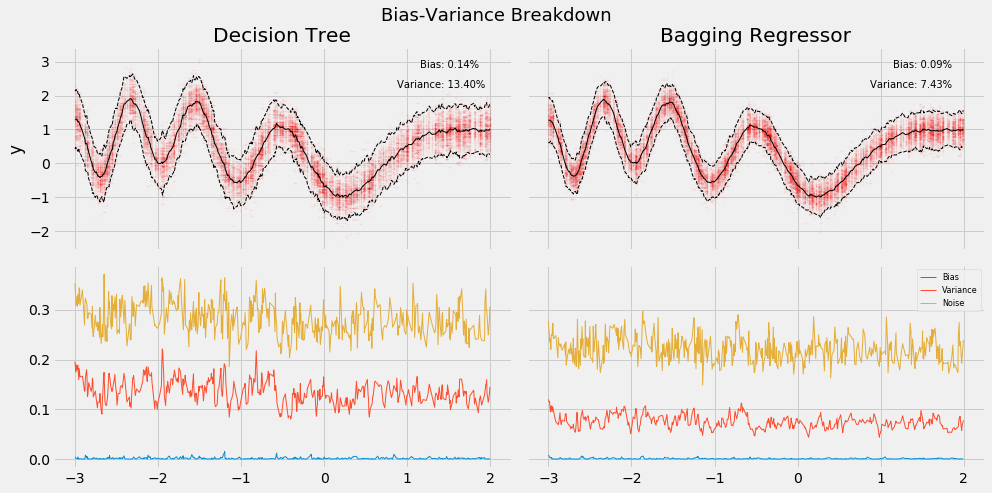

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14, 7), sharex=True, sharey='row')
axes = axes.flatten()
idx = pd.IndexSlice

for i, (model, data) in enumerate(predictions.items()):
    mean, std = data.mean(1), data.std(1).mul(2)
    (pd.DataFrame([mean.sub(std), mean, mean.add(std)]).T
     .sort_index()
     .plot(style=['k--', 'k-', 'k--'], ax=axes[i], lw=1, legend=False))
    (data.stack().reset_index()
     .rename(columns={'level_0': 'x', 0: 'y'})
     .plot.scatter(x='x', y='y', ax=axes[i], alpha=.02, s=2, color='r', title=model))
    r = result[model]
    m = r.mean()
    kwargs = {'transform': axes[i].transAxes, 'fontsize':10}
    axes[i].text(x=.8, y=.9, s=f'Bias: {m.bias:.2%}', **kwargs)
    axes[i].text(x=.75, y=.8, s=f'Variance: {m.variance:.2%}', **kwargs)
    
    (r.drop('error', axis=1).sort_index()
     .rename(columns=str.capitalize)
     .plot(ax=axes[i+2], lw=1, legend=False, stacked=True))

axes[-1].legend(fontsize=8)
fig.suptitle('Bias-Variance Breakdown', fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('bias_variance_bagging', dpi=600);

## Random Forests

### Classifier

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200,             # will change from 10 to 100 in version 0.22 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto',
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

In [16]:
rf_clf = RandomForestClassifier(n_estimators=10,
                                criterion='gini',
                                max_depth=None,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_features='auto',
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=1,
                                random_state=None,
                                verbose=0,
                                warm_start=False,
                                class_weight=None)

In [17]:
cv = OneStepTimeSeriesSplit(n_splits=10)
clf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {'n_estimators': [200, 400],
              'max_depth': [10, 15, 20],
              'min_samples_leaf': [50, 100],
              'max_features': ['auto']
              }

In [18]:
gridsearch_clf = GridSearchCV(estimator=clf,
                              param_grid=param_grid,
                              scoring='roc_auc',
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True,
                              verbose=1)

In [19]:
gridsearch_clf.fit(X=X, y=y_binary)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 44.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 189.6min finished


GridSearchCV(cv=<__main__.OneStepTimeSeriesSplit object at 0x7f6fdc51a0b8>,
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [200, 400], 'max_depth': [10, 15, 20], 'min_samples_leaf': [50, 100], 'max_features': ['auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [20]:
gridsearch_clf.best_params_

{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 50,
 'n_estimators': 200}

In [21]:
gridsearch_clf.best_score_

0.5088015278460444

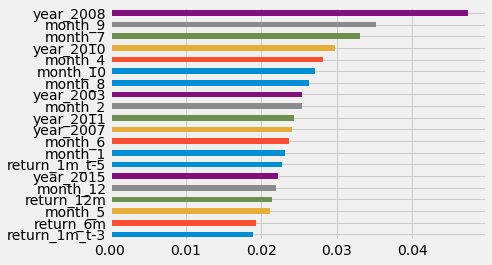

In [22]:
(pd.Series(gridsearch_clf.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False).iloc[:20].sort_values().plot.barh();)

### Regression

In [23]:
rf_reg = RandomForestRegressor(n_estimators=10, 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=None, 
                                verbose=0, 
                                warm_start=False)

In [24]:
param_grid = {'n_estimators': [200],
              'max_depth': [1,10, 20],
              'min_samples_leaf': [50, 100],
              'max_features': ['auto']
              }

In [25]:
gridsearch_reg = GridSearchCV(estimator=rf_reg,
                              param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True,
                              verbose=1)

In [28]:
y.shape

(1000,)

In [26]:
gridsearch_reg.fit(X=X, y=y)

ValueError: Found input variables with inconsistent numbers of samples: [431221, 1000]

In [ ]:
gridsearch_reg.best_params_

In [ ]:
f'{np.sqrt(-gridsearch_reg.best_score_):.2%}'

In [ ]:
f'{regression_benchmark():.2%}'

In [ ]:
rf_reg = RandomForestRegressor(n_estimators=1, 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=None, 
                                verbose=0, 
                                warm_start=False)